# look at skewers, turn them into wanted format

In [2]:
import numpy as np
from astropy.io import fits
import pylab as pl
import healpy as hp
from glob import glob

In [3]:
def get_folders(root):
    folder_list = glob(root + "*/", recursive = True)
    return folder_list

def get_file_from_folder(root):
    fname = glob(root + "*", recursive = True)[0]
    return fname

In [4]:
def wave_2_z(wave, emit=1215.67):
    red = (wave-emit)/emit
    return red

In [5]:
# def save fits file:
def save_catalog_to_fits(fname, data_matrix):
    c=[]
    dtype_to_fits_type = {'int64': 'K',
                          'float64': 'D',
                          'float32': 'E',
                          '<U6': '20A',
                          'bool': 'bool',
                          '>f8': 'D',
                          '>f4': 'E',
                         }
    
    for ii, keys in enumerate(data_matrix.keys()):
        col=fits.Column(name=keys, array=data_matrix[keys],
                        format=dtype_to_fits_type[str(data_matrix[keys].dtype)])
        c.append(col)
    t = fits.BinTableHDU.from_columns(c)
    t.writeto(fname)

In [5]:
hdu=fits.open('/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/skewers/output_files/13/1375/transmission-16-1375.fits.gz')

In [6]:
wave=hdu[2].data
ra=hdu[1].data['RA']
dec=hdu[1].data['DEC']
z=hdu[1].data['Z']

In [7]:
emit = 1215.67
red = (wave-emit)/emit

ind = red<3.0

## Compute mean flux ratio:

In [17]:
# compute the avg F:

num = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,27,28,30]
root = "/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/skewers/output_files/"

#N_spectra = 0
mean_spectra = np.zeros(len(red))
lambda_rf_min=1040
lambda_rf_max=1200
tot_weights=0
tot_flux=0
for ii in num:
    
    if ii%5 == 0:
        print(f"Working on directory {ii}/")
    
    froot = root + f"{ii}/"
    folder_list = get_folders(froot)
    
    for ffroot in folder_list:
        fname = get_file_from_folder(ffroot)
        hdu=fits.open(fname)
        F=hdu['F_LYA'].data
        zq=hdu[1].data['Z']
        
        in_forest=np.empty(F.shape, dtype=bool)
        for iq in range(len(zq)):
            lambda_obs_min=lambda_rf_min*(1+zq[iq])
            lambda_obs_max=lambda_rf_max*(1+zq[iq])
            in_forest[iq]=np.logical_and(wave > lambda_obs_min, wave < lambda_obs_max)
           
        # compute the avg of F:
        #mean_flux=np.zeros_like(wave)
        #mean_flux[weights>0]=np.sum(F*in_forest, axis=0)[weights>0]/weights[weights>0]
        tot_weights += np.sum(in_forest, axis=0)
        tot_flux += np.sum(F*in_forest, axis=0)

mean_spectra[tot_weights>0]=tot_flux[tot_weights>0]/tot_weights[tot_weights>0]
print(len(mean_spectra))

Working on directory 0/
Working on directory 5/
Working on directory 10/
Working on directory 15/
Working on directory 20/
Working on directory 25/
Working on directory 30/
15150


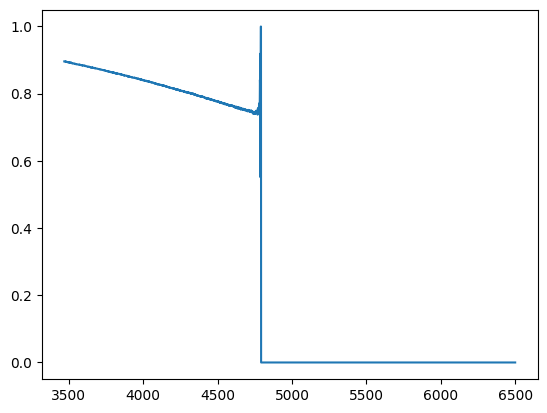

In [20]:
pl.plot(wave,mean_spectra)

In [19]:
# save this:
saveroot = "/pscratch/sd/q/qhang/desi-lya/"
np.savetxt(saveroot + "mean_F.txt", np.c_[wave, mean_spectra])

## Get delta_F

In [8]:
saveroot = "/pscratch/sd/q/qhang/desi-lya/"
mean_spectra = np.loadtxt(saveroot + "mean_F.txt")

Text(0, 0.5, '$<F>$')

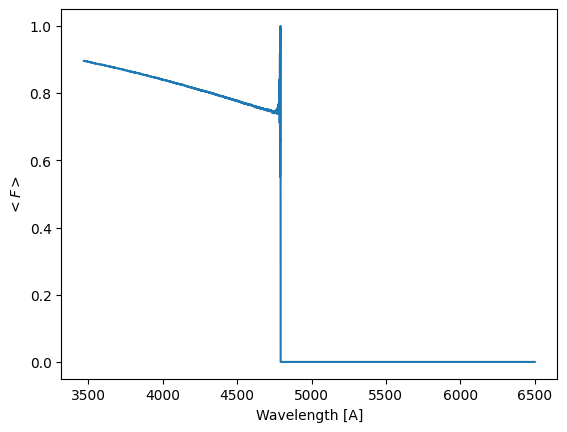

In [4]:
pl.plot(mean_spectra[:,0],mean_spectra[:,1])
pl.xlabel("Wavelength [A]")
pl.ylabel("$<F>$")

In [17]:
hdu=fits.open('/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/skewers/output_files/13/1375/transmission-16-1375.fits.gz')

wave=hdu[2].data
emit = 1215.67
lambda_rf_min=1040
lambda_rf_max=1200
red = (wave-emit)/emit
F = hdu['F_LYA'].data
zq=hdu[1].data['Z']
in_forest=np.empty(F.shape, dtype=bool)
for iq in range(len(zq)):
    lambda_obs_min=lambda_rf_min*(1+zq[iq])
    lambda_obs_max=lambda_rf_max*(1+zq[iq])
    in_forest[iq]=np.logical_and(wave > lambda_obs_min, wave < lambda_obs_max)

In [19]:
np.sum(in_forest,axis=1)

array([3075, 3164, 3114, ...,    0,  755, 1535])

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
148
348
348
348
348
348
349
348
348
142


/tmp/ipykernel_459329/4143171128.py:4: RuntimeWarning: divide by zero encountered in divide
  pl.plot(wave,F/mean_spectra[:,1]-1,label=r'Ly$\alpha$')


Text(0.5, 0, 'Redshift')

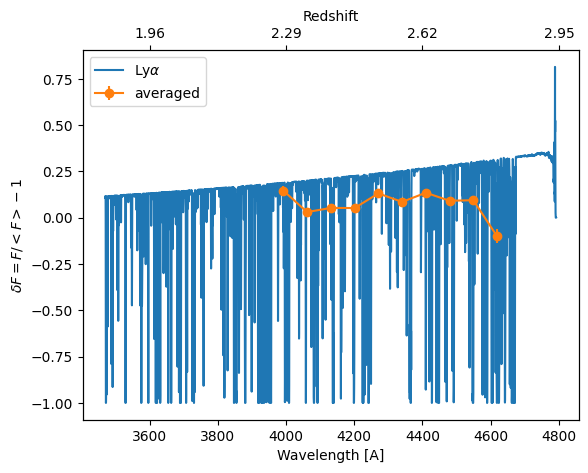

In [20]:
fig, axs = pl.subplots(1,1)
kk = 0
F = hdu['F_LYA'].data[kk]#[ind]
pl.plot(wave,F/mean_spectra[:,1]-1,label=r'Ly$\alpha$')
#plt.plot(wave,hdu['F_LYB'].data[0],label=r'Ly$\beta$')

pl.xlabel('Wavelength [A]')
pl.ylabel('$\\delta F = F/ <F>-1$')
#plt.xlim(3500,3700)
#plt.ylim(-0.05,1.05)
#plt.title('Lya & Lyb transmited flux fraction')

#plt.show()

# compute the averaged spectra:
nbin=20
ind = red<3.0
bin_edges = np.linspace(red[ind][0], red[ind][-1], nbin+1)
#print(bin_edges)
bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.

bin_tag = np.digitize(red, bin_edges)
print(np.unique(bin_tag))

for kk in range(1):
    avg_skewers = np.zeros(nbin)
    error = np.zeros(nbin)
    weight = in_forest[kk].astype(int)
    for ii in range(nbin):
        useind = bin_tag == ii+1
        if np.sum(weight[useind])!=0:
            avg_skewers[ii] = np.sum(hdu['F_LYA'].data[kk][useind]/mean_spectra[useind,1]-1)/np.sum(weight[useind])
            error[ii] = np.std(hdu['F_LYA'].data[kk][useind]/mean_spectra[useind,1]-1)/np.sqrt(sum(weight[useind]))
            print(np.sum(weight[useind]))
        else:
            avg_skewers[ii] = np.nan
    plot_ind = ~np.isnan(avg_skewers)
    pl.errorbar((bin_cen[plot_ind]+1)*emit, avg_skewers[plot_ind], yerr=error[plot_ind], 
                fmt='o-',label="averaged")
pl.legend()
    
ax2 = axs.twiny()
ax2.set_xlim(axs.get_xlim())
new_loc = np.array([3600, 4000, 4400, 4800])
ax2.set_xticks(new_loc)
new_x = np.round(wave_2_z(new_loc),2)
ax2.set_xticklabels(new_x)
ax2.set_xlabel("Redshift")

#pl.xlabel("redshift")
#pl.ylabel("$\\delta F$")

### save catalog:

In [24]:
num = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,27,28,30]
root = "/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/skewers/output_files/"
nbin=20
ind = red<3.0
bin_edges = np.linspace(red[ind][0], red[ind][-1], nbin+1)
#print(bin_edges)
bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
bin_tag = np.digitize(red, bin_edges)

# save the binedges and bins
saveroot = "/pscratch/sd/q/qhang/desi-lya/delta_F/"
fname = saveroot + "zbins.txt"
np.savetxt(fname, np.c_[bin_edges, np.append(bin_cen, 0)])

In [25]:
lambda_rf_min=1040
lambda_rf_max=1200

In [26]:
bin_cen, bin_cen[1]-bin_cen[0]

(array([1.88303154, 1.94030859, 1.99758565, 2.05486271, 2.11213977,
        2.16941683, 2.22669389, 2.28397095, 2.34124801, 2.39852507,
        2.45580213, 2.51307919, 2.57035625, 2.62763331, 2.68491037,
        2.74218743, 2.79946449, 2.85674155, 2.91401861, 2.97129567]),
 0.05727705955505358)

In [27]:
saveroot = "/pscratch/sd/q/qhang/desi-lya/"

for mm in num[1:]:
    froot = root + f"{mm}/"
    folder_list = get_folders(froot)
    savename = saveroot + f"delta_F/pixgroup_{mm}.fits"
    data_holder={}
    
    for ffroot in folder_list:
        fname = get_file_from_folder(ffroot)
        
        # now get delta_F, redshiftbin, ra, and dec: 
        hdu=fits.open(fname)
        ra=hdu[1].data['RA']
        dec=hdu[1].data['DEC']
        zq=hdu[1].data['Z']
        
        # get mask:
        F = hdu['F_LYA'].data
        in_forest=np.empty(F.shape, dtype=bool)
        for iq in range(len(zq)):
            lambda_obs_min=lambda_rf_min*(1+zq[iq])
            lambda_obs_max=lambda_rf_max*(1+zq[iq])
            in_forest[iq]=np.logical_and(wave > lambda_obs_min, wave < lambda_obs_max)
        
        avg_skewers = np.zeros((nbin,len(ra)))
        num_pix = np.zeros((nbin,len(ra)))
        weight = in_forest.astype(int)
        
        for ii in range(nbin):
            useind = bin_tag == ii+1
            norm = mean_spectra[useind,1]
            avg_skewers[ii,:] = np.sum(hdu['F_LYA'].data[:,useind]/norm[None,:]-1,axis=1)/np.sum(weight[:,useind],axis=1)
            num_pix[ii,:] = np.sum(weight[:,useind],axis=1)
            # for points outside of the weight,flag them
            ind_inf = np.isinf(avg_skewers[ii,:])
            ind_nan = np.isnan(avg_skewers[ii,:])
            avg_skewers[ii,ind_inf] = -99
            avg_skewers[ii,ind_nan] = -99
            #zeroind = np.sum(weight[:,useind],axis=1)==0
            #avg_skewers[ii,zeroind] = np.nan
        
        avg_skewers = avg_skewers.T
        num_pix = num_pix.T
        # now construct the catalogue:
        ram = np.outer(ra,np.ones(nbin))
        decm = np.outer(dec,np.ones(nbin))
        zsampbin = np.outer(np.ones(len(ra)),bin_cen)
        zsamptag = np.outer(np.ones(len(ra)),np.arange(len(bin_cen)))
        
        remove_ind = avg_skewers!=-99
        #remove_ind = (np.ones(len(avg_skewers))).astype(bool)
        
        if ffroot == folder_list[0]:
            data_holder["DELTA_F"] = avg_skewers[remove_ind]
            data_holder["NPIX"] = num_pix[remove_ind]
            data_holder["RA"] = ram[remove_ind]
            data_holder["DEC"] = decm[remove_ind]
            data_holder["Z"] = zsampbin[remove_ind]
            data_holder["Z_BIN"] = zsamptag[remove_ind]
        else:
            data_holder["DELTA_F"] = np.append(data_holder["DELTA_F"], avg_skewers[remove_ind])
            data_holder["NPIX"] = np.append(data_holder["NPIX"], num_pix[remove_ind])
            data_holder["RA"] = np.append(data_holder["RA"], ram[remove_ind])
            data_holder["DEC"] = np.append(data_holder["DEC"], decm[remove_ind])
            data_holder["Z"] = np.append(data_holder["Z"], zsampbin[remove_ind])
            data_holder["Z_BIN"] = np.append(data_holder["Z_BIN"], zsamptag[remove_ind])
        
    print("Number of objects: ", len(data_holder["DELTA_F"]))
    save_catalog_to_fits(savename, data_holder)
    print(f"saved: {savename}")

/tmp/ipykernel_459329/343654173.py:33: RuntimeWarning: divide by zero encountered in divide
  avg_skewers[ii,:] = np.sum(hdu['F_LYA'].data[:,useind]/norm[None,:]-1,axis=1)/np.sum(weight[:,useind],axis=1)
/tmp/ipykernel_459329/343654173.py:33: RuntimeWarning: invalid value encountered in divide
  avg_skewers[ii,:] = np.sum(hdu['F_LYA'].data[:,useind]/norm[None,:]-1,axis=1)/np.sum(weight[:,useind],axis=1)


Number of objects:  453192
saved: /pscratch/sd/q/qhang/desi-lya/delta_F/pixgroup_1.fits
Number of objects:  614315
saved: /pscratch/sd/q/qhang/desi-lya/delta_F/pixgroup_2.fits
Number of objects:  1226575
saved: /pscratch/sd/q/qhang/desi-lya/delta_F/pixgroup_3.fits
Number of objects:  1221527
saved: /pscratch/sd/q/qhang/desi-lya/delta_F/pixgroup_4.fits
Number of objects:  1208807
saved: /pscratch/sd/q/qhang/desi-lya/delta_F/pixgroup_5.fits
Number of objects:  1232102
saved: /pscratch/sd/q/qhang/desi-lya/delta_F/pixgroup_6.fits
Number of objects:  1189162
saved: /pscratch/sd/q/qhang/desi-lya/delta_F/pixgroup_7.fits
Number of objects:  441283
saved: /pscratch/sd/q/qhang/desi-lya/delta_F/pixgroup_8.fits
Number of objects:  478559
saved: /pscratch/sd/q/qhang/desi-lya/delta_F/pixgroup_9.fits
Number of objects:  857851
saved: /pscratch/sd/q/qhang/desi-lya/delta_F/pixgroup_10.fits
Number of objects:  1219521
saved: /pscratch/sd/q/qhang/desi-lya/delta_F/pixgroup_11.fits
Number of objects:  9832

In [14]:
# load this file to see if things work:
fin = fits.open("/pscratch/sd/q/qhang/desi-lya/delta_F/pixgroup_0.fits")
fin[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   48 / length of dimension 1                          
NAXIS2  =               524752 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    6 / number of table fields                         
TTYPE1  = 'DELTA_F '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'NPIX    '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'RA      '        

In [16]:
fin[1].data["NPIX"]

array([290., 348., 348., ..., 349., 348., 115.], dtype='>f8')

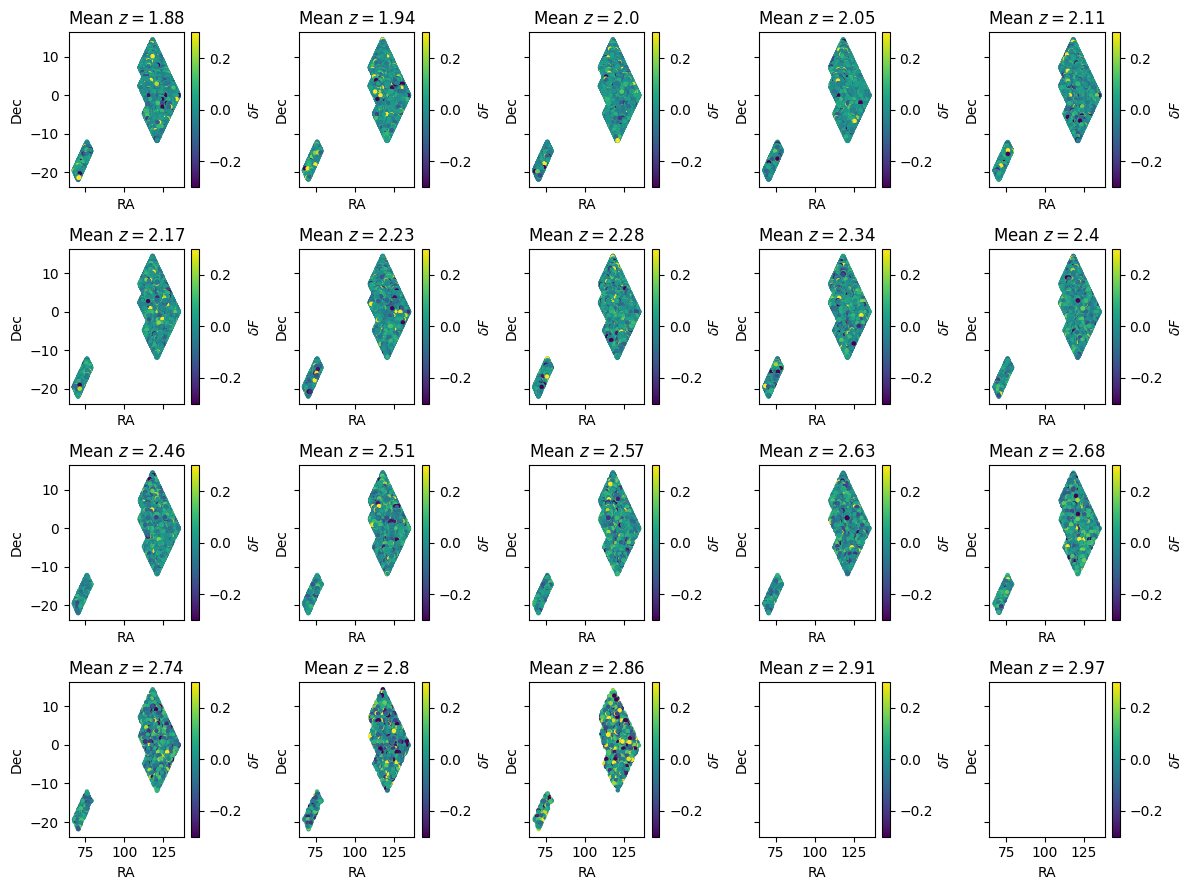

In [33]:
# now let's pick some bins and look at the distirbution:
fig,axarr=pl.subplots(4,5,figsize=[12,9],sharex=True,sharey=True)

z_bin = fin[1].data["Z_BIN"]
ra=fin[1].data["RA"]
dec=fin[1].data["DEC"]
delta_f=fin[1].data["DELTA_F"]

#axarr[1,2].axis("off")

for ii in range(4):
    for jj in range(5):
        kk = (ii*5+jj)
        pl.sca(axarr[ii,jj])
        use = z_bin==kk
        #use *= data_holder["DLETA_F"]!=0
        pl.scatter(ra[use], dec[use],c=delta_f[use],
                  vmax=0.3,vmin=-0.3,s=5)
        pl.colorbar(label="$\\delta F$")
        pl.title(f"Mean $z = {round(bin_cen[kk], 2)}$")
        pl.xlabel("RA")
        pl.ylabel("Dec")
        
pl.tight_layout()

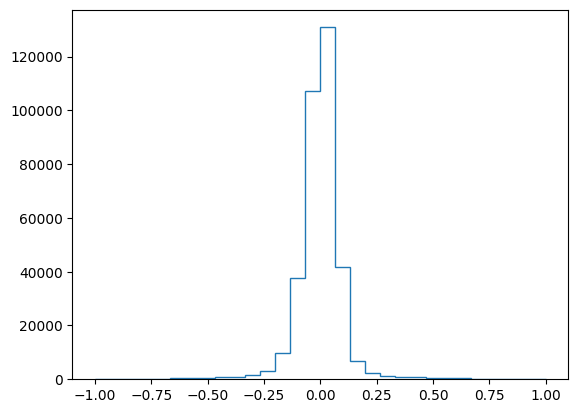

In [34]:
cc=pl.hist(data_holder["DELTA_F"],range=[-1,1],bins=30,histtype='step')

In [8]:
num = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,27,28,30]
root = "/pscratch/sd/q/qhang/desi-lya/delta_F/"

# for each tomo bin
nside=8
npix = int(12*nside**2)

lya_counts = np.zeros(int(12*nside**2))
for ii in num:
    fname = root + f"pixgroup_{ii}.fits"
    fin = fits.open(fname)
    
    ra = fin[1].data['RA']
    dec = fin[1].data['DEC']
    zbin = fin[1].data['Z_BIN']
    
    pix = hp.ang2pix(nside,
                 np.radians(90 - dec),
                 np.radians(ra))
    n = np.bincount(pix, minlength=npix)
    lya_counts += n

setting the output map dtype to [dtype('float64')]


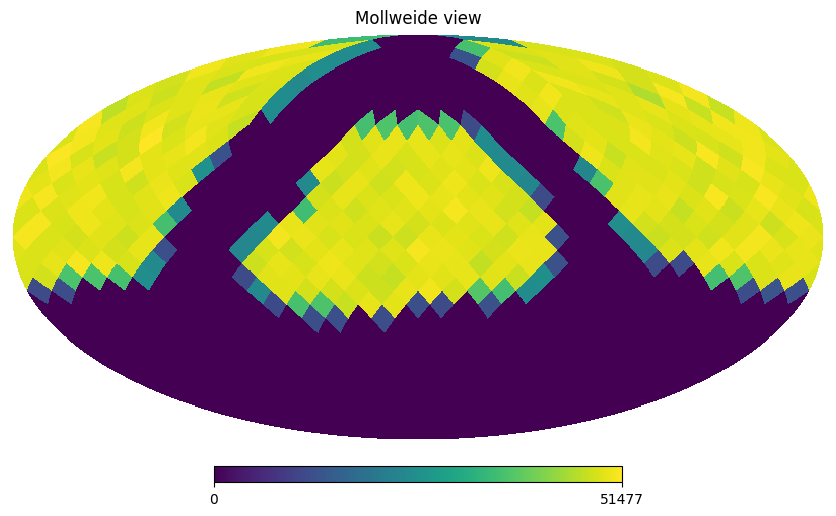

In [10]:
hp.mollview(lya_counts)
if(1):
    hp.write_map(f"lya_counts-nside-{nside}.fits", lya_counts)

In [6]:
# make a combined lya tracer file:

num = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,27,28,30]
root = "/pscratch/sd/q/qhang/desi-lya/delta_F/"

# for each tomo bin
#nside=8
data_holder = {}# at different redshift

# make a combined catalogue, let's load in first two redshift bins:
for ii in num:
    fname = root + f"pixgroup_{ii}.fits"
    fin = fits.open(fname)
    
    #ra = fin[1].data['RA']
    #dec = fin[1].data['DEC']
    #zbin = fin[1].data['Z_BIN']
    
    #pix = hp.ang2pix(nside,
    #             np.radians(90 - dec),
    #             np.radians(ra))
    #sel = np.isin(pix, test_pixel)

    #sel2 = np.isin(zbin[sel], np.array([5,6]))
    for key in fin[1].columns.names:
        if ii == 0:
            data_holder[key] = fin[1].data[key]
        else:
            data_holder[key] = np.append(data_holder[key], fin[1].data[key])
            
# save fits:
fname = root + "comb_pixgroup.fits"
save_catalog_to_fits(fname, data_holder)

In [7]:
print(len(data_holder[key]))

18260756
